In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra``
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier




# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('C:\Users\Pranav\Desktop\5th Sem\DMPAProject\RTADataset.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (Temp/ipykernel_7056/321653508.py, line 20)

In [ ]:
df = pd.read_csv('C:\Users\Pranav\Desktop\5th Sem\DMPAProject\RTADataset.csv')
column = df.columns
# all the categorical columns
cat_columns = [colname for colname in df.select_dtypes(["object", "category"])]
len(cat_columns)

30

In [ ]:
columns_to_drop = ['Fitness_of_casuality', 'Service_year_of_vehicle', 'Defect_of_vehicle']
df_dropped = df.drop(columns=columns_to_drop)


df_dropped.replace('unknown', 'Unknown', inplace=True)
df_dropped.Work_of_casuality = df_dropped.Work_of_casuality.fillna('Unknown') # na values sent to 'Unknown' category
# same was done for all the columns containing 'Unknown' as a value in the row
columns_with_unknown = df_dropped.columns[df_dropped.isin(['Unknown']).any()]
for column in columns_with_unknown:
    df_dropped[column] = df_dropped[column].fillna('Unknown')

# fill missing values
for column in df_dropped.columns:
    mode_value = df_dropped[column].mode()[0]
    df_dropped[column].fillna(mode_value, inplace=True)

In [ ]:
# Extract the time portion and store it as a new column
df_dropped['Time'] = df_dropped['Time'].str.split(' ').str[1]
# Define time ranges for the categories
bins = [0, 6, 12, 18, 24]  # Morning, Afternoon, Evening, Night
labels = ['Night', 'Morning', 'Afternoon', 'Evening']
# Create a new categorical column based on the time ranges
df_dropped['Time'] = pd.cut(df_dropped['Time'], bins=bins, labels=labels, right=False)




In [ ]:
all_columns = df_dropped.columns.tolist()
ordinal_columns = ['Time', 'Day_of_week', 'Age_band_of_driver', 'Educational_level', 'Driving_experience', 'Light_conditions', 'Age_band_of_casualty', 'Casualty_severity']
label_columns = [col for col in all_columns if col not in ordinal_columns]
columns_to_remove = ['Number_of_casualties', 'Number_of_vehicles_involved']
label_columns = [col for col in label_columns if col not in columns_to_remove]

In [ ]:
from sklearn.preprocessing import LabelEncoder

def encode_columns(df, label_encode_columns=None, ordinal_encode_columns=None):
   
    encoded_df = df.copy()
    
    # Label Encoding
    if label_encode_columns:
        label_encoder = LabelEncoder()
        for column in label_encode_columns:
            encoded_df[column] = label_encoder.fit_transform(encoded_df[column])
    
    # Ordinal Encoding
    if ordinal_encode_columns:
        for column, category_order in ordinal_encode_columns.items():
            category_mapping = {category: index for index, category in enumerate(category_order)}
            encoded_df[column] = encoded_df[column].map(category_mapping)
    
    return encoded_df

In [ ]:
label_encode_cols = label_columns
ordinal_encode_cols = {'Time': ['Morning', 'Afternoon', 'Evening', 'Night'],'Day_of_week': ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'], 'Age_band_of_driver': ['Unknown', 'Under 18', '18-30', '31-50', 'Over 51'], 'Educational_level': ["Unknown", "Illiterate", "Writing & reading", "Elementary school", "Junior high school","High school","Above high school"], 'Driving_experience': ['Unknown', 'No Licence', 'Below 1yr', '1-2yr', '2-5yr', '5-10yr', 'Above 10yr'], 'Light_conditions': ['Darkness - no lighting', 'Darkness - lights unlit', 'Darkness - lights lit', 'Daylight'], 'Age_band_of_casualty': ['na', '5', 'Under 18', '18-30', '31-50', 'Over 51'], 'Casualty_severity': ['na', '1', '2', '3']}

# Encode the specified columns
df_ord = encode_columns(df_dropped, label_encode_columns=label_encode_cols, ordinal_encode_columns=ordinal_encode_cols)

# Replace NaN values with 0 in 'Time' and 'Driving_experience' columns
df_ord['Time'].fillna(0, inplace=True)
df_ord['Driving_experience'].fillna(0, inplace=True)

# Convert columns to integers
df_ord['Time'] = df_ord['Time'].astype(int)
df_ord['Driving_experience'] = df_ord['Driving_experience'].astype(int)

# Print the encoded DataFrame
df_ord.head()


,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Area_accident_occured,...,Number_of_casualties,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity
0,0,1,2,1,6,0,3,0,3,8,...,2,2,3,2,0,0,6,5,9,2
1,0,1,3,1,4,0,6,11,3,4,...,2,2,3,2,0,0,6,5,16,2
2,0,1,2,1,4,0,3,5,3,7,...,2,2,0,1,4,3,0,5,0,1
3,0,0,2,1,4,0,5,11,0,4,...,2,2,2,0,3,3,0,5,1,2
4,0,0,2,1,4,0,4,0,3,2,...,2,2,3,2,0,0,6,5,16,2


In [ ]:
# Define label_encode_cols

# Encode the specified columns
df_ord = encode_columns(df_dropped, label_encode_columns=label_encode_cols, ordinal_encode_columns=ordinal_encode_cols)

# Handle missing values in 'Time' and 'Driving_experience' columns
df_ord['Time'].fillna(0, inplace=True)
df_ord['Driving_experience'].fillna(0, inplace=True)

# Convert columns to integers
df_ord['Time'] = df_ord['Time'].astype(int)
df_ord['Driving_experience'] = df_ord['Driving_experience'].astype(int)

# Print the encoded DataFrame
df_ord.head()


,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Area_accident_occured,...,Number_of_casualties,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity
0,0,1,2,1,6,0,3,0,3,8,...,2,2,3,2,0,0,6,5,9,2
1,0,1,3,1,4,0,6,11,3,4,...,2,2,3,2,0,0,6,5,16,2
2,0,1,2,1,4,0,3,5,3,7,...,2,2,0,1,4,3,0,5,0,1
3,0,0,2,1,4,0,5,11,0,4,...,2,2,2,0,3,3,0,5,1,2
4,0,0,2,1,4,0,4,0,3,2,...,2,2,3,2,0,0,6,5,16,2


In [ ]:
from sklearn.model_selection import train_test_split

# splitting df_ord
X = df_ord.drop('Accident_severity', axis=1)
y = df_ord['Accident_severity']

Xord_train, Xord_test, yord_train, yord_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(Xord_train.shape, Xord_test.shape, yord_train.shape, yord_test.shape)


(9852, 28) (2464, 28) (9852,) (2464,)


In [ ]:
train, test = train_test_split(df_ord, test_size=0.2, random_state=42, stratify=df_ord['Accident_severity'])
print(train.shape,test.shape)

(9852, 29) (2464, 29)


In [ ]:
# creating a list of columns to be mean encoded leaving the ordinally encoded columns

columns_to_include = df_dropped.columns.tolist()
# values_to_remove = []
values_to_remove = ['Accident_severity', 'Number_of_casualties', 'Number_of_vehicles_involved', 'Casualty_severity', 'Age_band_of_casualty', 'Light_conditions', 'Driving_experience', 'Educational_level', 'Age_band_of_driver', 'Day_of_week', 'Time']
for value in values_to_remove:    
    columns_to_include.remove(value)

In [ ]:
def mean_encode(train, test, columns_to_include):
    # mean encoding
    df_mean = train.copy()
    df_mean_test = test.copy()
    for col in columns_to_include:
        category_means = df_mean.groupby(col)['Accident_severity'].mean().to_dict()
        df_mean[col] = df_mean[col].map(category_means)
        df_mean_test[col] = df_mean_test[col].map(category_means)

    df_mean['Time'] = df_mean['Time'].astype(int)
    df_mean_test['Time'] = df_mean_test['Time'].astype(int)
    
    # Fill missing values
    for column in df_mean_test.columns:
        mode_value = df_mean_test[column].mode()[0]
        df_mean_test[column].fillna(mode_value, inplace=True)
    
    return df_mean, df_mean_test

# Usage example
mean_train, mean_test = mean_encode(train, test, columns_to_include)
mean_train.head()


,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Area_accident_occured,...,Number_of_casualties,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity
6068,0,1,0,1.831273,4,1.836437,4,1.856743,1.831884,1.825641,...,1,1.836469,1.826186,1.837595,4,2,1.827156,1.833883,1.847007,2
5981,0,0,2,1.831273,4,1.836437,5,1.814371,1.831884,1.840778,...,1,1.836469,1.828635,1.837595,3,2,1.841883,1.827586,1.812918,2
10572,0,5,2,1.831273,3,1.836437,5,1.826353,1.831884,1.835248,...,1,1.843792,1.827893,1.837595,4,2,1.827156,1.833883,1.816344,1
4862,0,0,2,1.831273,3,1.836437,3,1.789474,1.831884,1.846715,...,1,1.827715,1.826186,1.821658,3,3,1.836100,1.833883,1.826268,2
5016,0,4,0,1.831273,4,1.836437,5,1.826353,1.831884,1.802639,...,2,1.836469,1.826186,1.821658,3,3,1.836100,1.833883,1.841226,2


In [ ]:
# splitting (df_mean) mean_train and mean_test
Xmean_train = mean_train.drop('Accident_severity', axis=1)
ymean_train = mean_train['Accident_severity']

Xmean_test= mean_test.drop('Accident_severity', axis=1)
ymean_test = mean_test['Accident_severity']
print(Xmean_train.shape, Xmean_test.shape, ymean_train.shape, ymean_test.shape)

(9852, 28) (2464, 28) (9852,) (2464,)


In [ ]:
def modelling(X_train, y_train, X_test, y_test, **kwargs):
    scores = {}
    models = {}
    
    if 'xgb' in kwargs.keys() and kwargs['xgb']:
        xgb = XGBClassifier()
        xgb.fit(X_train._get_numeric_data(), np.ravel(y_train, order='C'))
        y_pred = xgb.predict(X_test._get_numeric_data())
        scores['xgb'] = f1_score(y_test, y_pred, average='micro')
        models['xgb'] = xgb

    if 'rf' in kwargs.keys() and kwargs['rf']:
        rf = RandomForestClassifier(n_estimators=200)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        scores['rf'] = f1_score(y_test, y_pred, average='micro')
        models['rf'] = rf

    if 'extree' in kwargs.keys() and kwargs['extree']:
        extree = ExtraTreesClassifier()
        extree.fit(X_train, y_train)
        y_pred = extree.predict(X_test)
        scores['extree'] = f1_score(y_test, y_pred, average='micro')
        models['extree'] = extree

    return scores, models


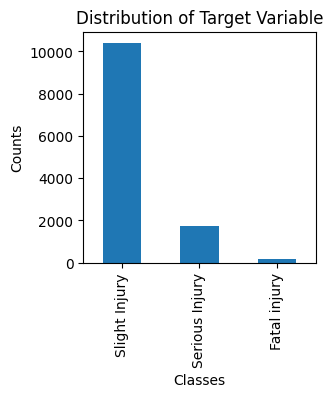

In [ ]:
  # Import the matplotlib library
import matplotlib.pyplot as plt
# you can see that our target is highly unbalanced
target_counts = df["Accident_severity"].value_counts()

# Create a bar plot
plt.figure(figsize=(3, 3))
target_counts.plot(kind='bar')
plt.title('Distribution of Target Variable')
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.show()


In [ ]:
# upsampling using SMOTE or SMOTETomek 

def upsample(tech, X_train, y_train):
    counter = Counter(y_train)

#     print("=============================")

    for k,v in counter.items():
        per = 100*v/len(y_train)
#         print(f"Class= {k}, n={v} ({per:.2f}%)")
        
    if tech == 'smote':
        oversample = SMOTE(random_state=42)
        X_train, y_train = oversample.fit_resample(X_train, y_train)
    elif tech =='smotet':
        smt = SMOTETomek(random_state=42)
        X_train, y_train = smt.fit_resample(X_train, y_train)
        
    counter = Counter(y_train)

#     print("=============================")

    for k,v in counter.items():
        per = 100*v/len(y_train)
#         print(f"Class= {k}, n={v} ({per:.2f}%)")

#     print("=============================")
#     print("Upsampled data shape: ", X_train.shape, y_train.shape)
    return X_train,y_train

In [ ]:
def upsample_train(tech, X_train, X_test, y_train, y_test): 
    """
    Performs upsampling and modelling over the data given
    Args: 
        tech (str): techinque by which to perform upsampling. SMOTE or SMOTETomek
    """
    X_train,y_train = upsample(tech, X_train, y_train)
    print('')
    scores,models = modelling(X_train,y_train, X_test, y_test, xgb=True, rf=True, extree=True)
    print(scores)
    return scores,models

In [ ]:
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.metrics import (accuracy_score, 
                            classification_report,
                            recall_score, precision_score, f1_score,
                            confusion_matrix)
upsample_train('smote', Xord_train, Xord_test, yord_train, yord_test)

C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dty

{'xgb': 0.7775974025974026, 'rf': 0.791396103896104, 'extree': 0.8051948051948051}


({'xgb': 0.7775974025974026,
  'rf': 0.791396103896104,
  'extree': 0.8051948051948051},
 {'xgb': XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=None,
                num_parallel_tree=None, objective='multi:softprob', ...),
  'rf': RandomForestClassifier(n_estimators=200),
  'extree': ExtraTreesClassifier()})

In [ ]:
# mean + label with smote
upsample_train('smote', Xmean_train, Xmean_test, ymean_train, ymean_test)

C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dty

{'xgb': 0.8486201298701299, 'rf': 0.8498376623376623, 'extree': 0.8433441558441559}


({'xgb': 0.8486201298701299,
  'rf': 0.8498376623376623,
  'extree': 0.8433441558441559},
 {'xgb': XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=None,
                num_parallel_tree=None, objective='multi:softprob', ...),
  'rf': RandomForestClassifier(n_estimators=200),
  'extree': ExtraTreesClassifier()})

In [ ]:
# ord with smotetomek
upsample_train('smotet', Xord_train, Xord_test, yord_train, yord_test)

C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dty

{'xgb': 0.7771915584415584, 'rf': 0.7861201298701299, 'extree': 0.8003246753246753}


({'xgb': 0.7771915584415584,
  'rf': 0.7861201298701299,
  'extree': 0.8003246753246753},
 {'xgb': XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=None,
                num_parallel_tree=None, objective='multi:softprob', ...),
  'rf': RandomForestClassifier(n_estimators=200),
  'extree': ExtraTreesClassifier()})

In [ ]:
# mean + label with smotetomek
upsample_train('smotet', Xmean_train, Xmean_test, ymean_train, ymean_test)


C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dty

{'xgb': 0.849025974025974, 'rf': 0.8457792207792206, 'extree': 0.8445616883116883}


({'xgb': 0.849025974025974,
  'rf': 0.8457792207792206,
  'extree': 0.8445616883116883},
 {'xgb': XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=None,
                num_parallel_tree=None, objective='multi:softprob', ...),
  'rf': RandomForestClassifier(n_estimators=200),
  'extree': ExtraTreesClassifier()})

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

# Function to perform modeling with Random Forest
def random_forest_model(X_train, y_train, X_test, y_test):
    rf = RandomForestClassifier(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='micro')
    
    return accuracy, f1, rf

# Original dataset
print("Original Dataset:")
accuracy_original, f1_original, _ = random_forest_model(Xord_train, yord_train, Xord_test, yord_test)
print(f"Accuracy: {accuracy_original:.4f}")
print(f"F1 Score: {f1_original:.4f}")

# Mean-encoded dataset
print("\nMean Encoded Dataset:")
accuracy_mean_encoded, f1_mean_encoded, _ = random_forest_model(Xmean_train, ymean_train, Xmean_test, ymean_test)
print(f"Accuracy: {accuracy_mean_encoded:.4f}")
print(f"F1 Score: {f1_mean_encoded:.4f}")


Original Dataset:
Accuracy: 0.8397
F1 Score: 0.8397

Mean Encoded Dataset:
Accuracy: 0.8478
F1 Score: 0.8478
